# Workflow with BRD4(1)

In this notebook, we introduce how to deal with common problems that arise when modelling proteins with Markov state models (MSMs). Overall, the notebook serves as an example workflow for analyzing molecular dynamics trajectories.

Maintainers: [@lraich](https://github.com/lraich) and [@psolsson](https://github.com/psolsson)

**Remember**:
- to run the currently highlighted cell, hold <kbd>&#x21E7; Shift</kbd> and press <kbd>&#x23ce; Enter</kbd>;
- to get help for a specific function, place the cursor within the function's brackets, hold <kbd>&#x21E7; Shift</kbd>, and press <kbd>&#x21E5; Tab</kbd>;
- you can find the full documentation at [PyEMMA](http://www.pyemma.org) and [Deeptime](https://deeptime-ml.github.io/latest/index.html).

---

The system under study is BRD4(1), a bromodomain of family II for which we have $64$ independent $1$ $\mu$s trajectories. The simulations were carried out with explicit solvent, but the files only contain protein atomic positions that are already superimposed and saved every $0.1$ ns. We aim to capture a novel conformational change in which the ZA-loop is displaced form the $\alpha$$_A$-helix [[Raich]](https://www.pnas.org/content/118/4/e2017427118), as shown in section __c__ of the following figure:

<img src="./figures/figure1.png" width="800" height="300" />

> __Figure 1-__ (__a__) General structure of bromodomains represented by CECR2 of family I. The ZA-loop is depicted in white and the $\alpha$$_A$-helix in blue. The closeup shows two conserved hydrogen bonds that wrap the ZA-loop with the helix, as well as a conserved aspartate. (__b__) Sequence alignment of representative bromodomains of each of the 8 families. The yellow star represents the conserved aspartate. (__c__) Novel conformational change in BRD4(1) of family II. The cyan structure represents the crystal-like "closed" state, and the yellow structure the novel "open" state.
---
The general workflow will involve the following protocol:
> [1. Load and featurize the data](#1.-Load-and-featurize-the-data)<Br>
> [2. Dimensionality reduction](#2.-Dimensionality-reduction)<Br>
> [3. Data visualization](#3.-Data-visualization)<Br>
> [4. Clusterize the data](#4.-Clusterize-the-data)<Br>
> [5. MSM estimation and validation](#5.-Markov-state-model-estimation-and-validation)<Br>
> [6. Computing properties of interest](#6.-Computing-properties-of-interest)<Br>
> [7. Final remarks and advices](#Final-remarks-and-advices)<Br>

#### 1. Load and featurize the data

We will first load all libraries we need, and subsequently define the paths to a reference PDB structure of the system and to each trajectory.

In [1]:
%matplotlib inline
import pyemma,deeptime,numpy,pickle
import mdtraj,pandas,subprocess,itertools
import matplotlib.pyplot as plt
from IPython.display import display_html

print("PyEMMA version:",pyemma.__version__)
print("Deeptime version:",deeptime.__version__)

PyEMMA version: 2.5.9
Deeptime version: 0.2.9


In [2]:
# Define frame saving frequency, paths to PDB and trajectories
stept=0.1 # ns
pdb="/web/ftp.imp.fu-berlin.de/pub/raich/tutorial/data/brd4-1-min.pdb"
fls=["/web/ftp.imp.fu-berlin.de/pub/raich/tutorial/data/brd4-1_{}-cent.xtc".format(i) for i in range(1,64+1)]

print("Total trajectories: {}  Saving frequency: {:1.1f} ns".format(len(fls),stept))

Total trajectories: 64  Saving frequency: 0.1 ns


Now we are ready to load and featurize the data in PyEMMA:

In [3]:
# First we create a feature object from the PDB and subsequently print the topology object.
feat=pyemma.coordinates.featurizer(pdb)
print(feat.topology)

# Then we add features to the object. We will start by using CA-CA pair distances from the section highlighted
# in Figure 1 C. Note we use the flag periodic=False since we have previously superposed our trajectory data.
feat.add_distances(feat.pairs(feat.topology.select("resid 24 to 70 and name CA")),periodic=False)
print("First feature included:",feat.describe()[0])

# Now we load in memory the featurized data, i.e. all pairwise distances over time (10.000 steps per trajectory).
# We could also stream the data using pyemma.coordinates.source(fls,feautres=feat) in case we have not enough
# memory available.
feat_data=pyemma.coordinates.load(fls,features=feat)

print("Frames per trajectory: {} Feature dimension: {}".format(feat_data[0].shape[0],feat_data[0].shape[1]))

<mdtraj.Topology with 1 chains, 119 residues, 2001 atoms, 2030 bonds>
First feature included: DIST: ARG 25 CA 395 - VAL 26 CA 419


Obtaining file info:   0%|                               | 0/64 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|                   | 0/64 [00:00<?, ?it/s]

Frames per trajectory: 10000 Feature dimension: 1081


----------
#### 2. Dimensionality reduction

At this point, given the high dimensionality of the data (1081 distances), we will reduce it using [TICA](https://aip.scitation.org/doi/abs/10.1063/1.4811489) (Time-lagged Independent Components Analysis), a dimensionality reduction technique that maximizes the autocorrelation of each independent component. TICA depends on two hyper-parameters: a lagtime and the number of TICs to keep. We can use the [VAMP-2 score](https://arxiv.org/abs/1707.04659) to guide their selection.

Now we will test different lagtimes and dimensions. The longest trajectory is of 1000 ns, and thus
the lagtime should be between 0 and 1000 ns. The longer the lagtime, the less (fast) processes will be resolved by the model, i.e. we loose time resolution but we gain in simplicity. The more the dimensions, the more processes will be taken into account (at the cost of increasing complexity).
<Br><Br>__⚠️ Note that the following cell is time consuming, and so during the tutorial we just load precomputed data.__

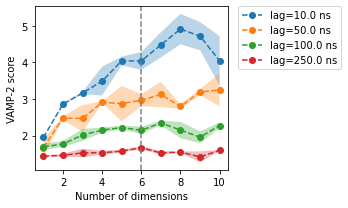

In [4]:
# We will compute the VAMP-2 score for e.g. the first 10 dimensions
# and lag times between 10 and 250 ns (100-2500 steps).
lags=[100,500,1000,2500]
dims=[i+1 for i in range(10)]

# Here we stride the data to speed up all calculations
stride=10
strided_data=[f[::stride] for f in feat_data]

# This computation takes c.a. 8 minutes (Intel(R) Xeon(R) W-2123 CPU @ 3.60GHz)
scores,errors=[],[]
for lag,dim in itertools.product(lags,dims):
    tica_estimator=deeptime.decomposition.TICA(lagtime=int(lag/stride),dim=dim)
    vamp_scores=deeptime.decomposition.vamp_score_cv(tica_estimator,trajs=strided_data,n=3,blocksplit=False)
    scores.append(vamp_scores.mean())
    errors.append(vamp_scores.std())
scores=numpy.array(scores).reshape(-1,len(dims))
errors=numpy.array(errors).reshape(-1,len(dims))

# Save scores in disk
subprocess.call("mkdir ./models",shell=True)
numpy.savez("./models/vamp2-scores.npz",scores=scores,errors=errors)

# Load scores
scores=numpy.load("./models/vamp2-scores.npz")["scores"]
errors=numpy.load("./models/vamp2-scores.npz")["errors"]

# Plot the results
fig,ax=plt.subplots(figsize=(5,3))
for i,lag in enumerate(lags):
    ax.fill_between(dims,scores[i]-errors[i],scores[i]+errors[i],alpha=0.3,facecolor="C{}".format(i))
    ax.plot(dims,scores[i],"--o",color="C{}".format(i),label="lag={} ns".format(lag*stept))
ax.axvline(6,ls="--",c="gray")
ax.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.)
ax.set_xlabel("Number of dimensions")
ax.set_ylabel("VAMP-2 score")
fig.tight_layout()

From the plot above we clearly see that __above 6 dimensions__ there is practically __no gain__ in VAMP-2 score. This means that the first 6 dimensions contain all the relevant kinetic information of the system, the slow processes. Let's do a TICA with lagtime 10 ns to see how each of the components look. 

In [5]:
# TICA dimensionality reduction. According to the VAMP2 plot in the previous cell, above 6 dimensions there is
# no gain in kinetic information, and thus we could use the flag dim=6 inside the object to limit the amount of
# data loaded into memory. However, here we will not restrict the number of dimensions to see all them.
tica=deeptime.decomposition.TICA(lagtime=100).fit(feat_data).fetch_model()
tica_out=tica.transform(feat_data)
tica_cnc=numpy.concatenate(tica_out)
print(tica_cnc.shape)

(640000, 496)


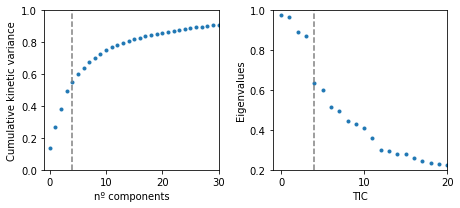

In [6]:
# Here we plot the cumulative kinetic variance
fig,ax=plt.subplots(ncols=2,figsize=(6.5,3))
ax[0].scatter([i for i in range(tica.output_dimension)],tica.cumulative_kinetic_variance[:tica.output_dimension],marker='.')
ax[0].set_xlabel("nº components")
ax[0].set_ylabel("Cumulative kinetic variance")
ax[0].set_xticks(numpy.arange(0,tica.output_dimension,10))
ax[0].axvline(4,ls="--",c="gray")
ax[0].set_ylim(0,1)
ax[0].set_xlim(-1,30)

# Here we plot the spectral gap
ax[1].scatter([i for i in range(tica.output_dimension)],tica.singular_values[:tica.output_dimension],marker='.')
ax[1].set_xlabel("TIC")
ax[1].set_ylabel("Eigenvalues")
ax[1].set_xticks(numpy.arange(0,tica.output_dimension,10))
ax[1].axvline(4,ls="--",c="gray")
ax[1].set_xlim(-1,20)
ax[1].set_ylim(0.2,1)

#ax[1].set_ylim(0,1)
fig.tight_layout()

Looking at the cumulative kinetic variance we can see a clear diminishing return when including more TICs, particularly above 4 components. However, deciding based on this metric is not trivial. Differences between eigenvalues give us an indicator for the timescale separation of processes captured by the different TICs. When gaps (difference between eigenvalues) become smaller, we want to stop including TICs as the effectiveness of MSMs relies on separation of timescales. We observe a large gap in between TICs 3 and 4 (0-indexing), and then a second smaller gap between TICs 5 and 6, suggesting that 4-6 TICs may be a good choice. Overall, we see a good agreement with the predictions from the VAMP-2 score analysis. 

Again, we could select just 6 dimensions, however we will select several components (e.g. up to 75% of the cumulative kinetic variance) to illustrate the relationship between these plots and the structure of the TIC distributions.

In [7]:
# Select components up to 0.75 cumulative variance
sel=[tic for tic,bol in enumerate(tica.cumulative_kinetic_variance<=0.75) if bol==True]
print("Dimension: {}".format(len(sel)))

Dimension: 10


-----------
#### 3. Data visualization

This will help us to identify potential pitfalls or lacks in our data, as well as to decide if all what we have predicted with the VAMP-2 score is meaningful or not. We will start by checking the substructure of each individual component, i.e. if they have multiple minima that could indicate certain degree of metastability.

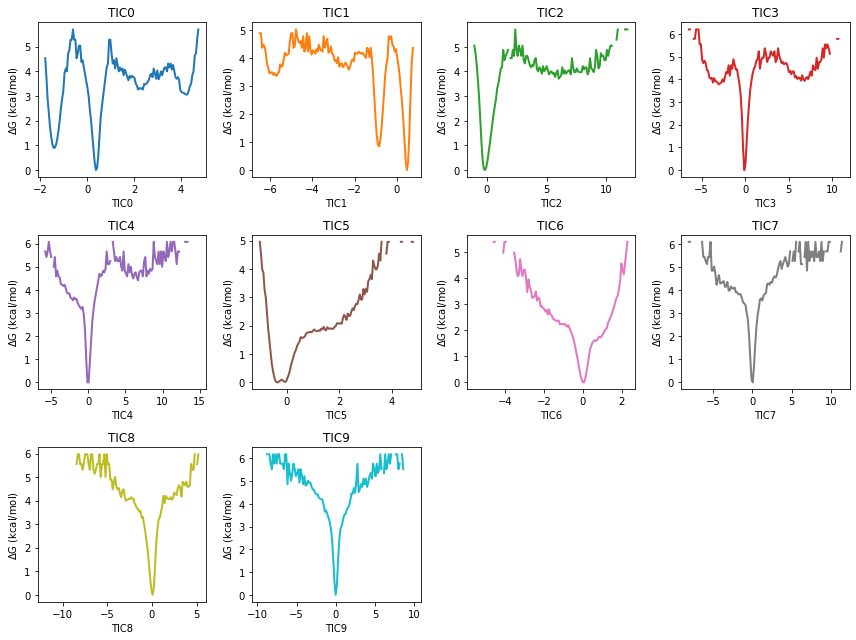

In [8]:
# Plot free energy profiles
cols=4
rows=int(numpy.ceil((len(sel))/cols))
fig,ax=plt.subplots(rows,cols,figsize=(3*cols,3*rows))
for i,ax_ in enumerate(ax.ravel()):
    if i>=len(sel):
        fig.delaxes(ax_)
        continue
    h=numpy.histogram(tica_cnc[::10,sel[i]],bins=128) #stride of 10
    ax_.plot((h[1][1:]+h[1][:-1])/2,[-0.6*numpy.log(x/max(h[0])) if x>0 else None for x in h[0]],
             linewidth=2,color="C{}".format(i));
    ax_.set_title("TIC{}".format(sel[i]))
    ax_.set_xlabel("TIC{}".format(sel[i]))
    ax_.set_ylabel(r"$\Delta$G (kcal/mol)")
fig.tight_layout()

The first four TICs (TIC0-TIC3) show several free energy minima, suggesting that they separate meta-stable states that that contribute to the VAMP-2 score. The next three TICs (TIC4-TIC6) also have some substructure, though it is generally very shallow. Above those, TICs present a single peak and are nearly Gaussian-like (i.e. they contain fast processes).

Let's check what are the input features that correlate with each of the TICs, this will help us to understand what do they describe:

In [9]:
# Print input features that have high correlation with TIC components
for s in sel:
    print("TIC{}".format(s))
    print("----------------------------------")
    argsorted=numpy.abs(tica.feature_component_correlation[:,s]).argsort()[::-1]
    corr_sort=tica.feature_component_correlation[argsorted,s]
    for i in range(5):
        print("{:5.2f} {}".format(corr_sort[i]/abs(corr_sort[0]),feat.describe()[argsorted[i]]))
    print('')

TIC0
----------------------------------
-1.00 DIST: ASP 45 CA 757 - ARG 70 CA 1177
-1.00 DIST: ASP 45 CA 757 - LEU 71 CA 1201
-0.99 DIST: ASP 45 CA 757 - THR 66 CA 1100
-0.99 DIST: ASP 45 CA 757 - LYS 69 CA 1155
-0.99 DIST: ASP 45 CA 757 - ILE 67 CA 1114

TIC1
----------------------------------
-1.00 DIST: VAL 47 CA 779 - PRO 61 CA 1041
-0.98 DIST: VAL 47 CA 779 - MET 62 CA 1047
-0.97 DIST: VAL 47 CA 779 - THR 60 CA 1019
-0.96 DIST: VAL 47 CA 779 - LYS 59 CA 997
-0.94 DIST: VAL 47 CA 779 - ASP 63 CA 1064

TIC2
----------------------------------
-1.00 DIST: LYS 48 CA 795 - LYS 56 CA 937
-0.99 DIST: ALA 46 CA 769 - TYR 55 CA 916
-0.93 DIST: LYS 48 CA 795 - TYR 55 CA 916
 0.88 DIST: ASP 53 CA 883 - LYS 56 CA 937
 0.84 DIST: TYR 54 CA 895 - PRO 61 CA 1041

TIC3
----------------------------------
 1.00 DIST: PRO 43 CA 735 - LYS 48 CA 795
 0.94 DIST: GLN 42 CA 710 - LYS 48 CA 795
 0.88 DIST: GLN 41 CA 693 - LYS 48 CA 795
 0.83 DIST: PRO 43 CA 735 - ASN 50 CA 836
 0.83 DIST: GLN 42 CA 710 - A

These correlations show that e.g. the CaCa pairwise distance between Asp45 and Arg70 is anticorrelated. We can visualize those residues to have a simple idea of the process, but for complex components one single distance may not be enough. Alternatively, we can output structures along the TIC of interest:

In [10]:
# Extract structures along TICs
source=pyemma.coordinates.source(fls,features=feat)
snaps,num=10,[t.shape[0] for t in tica_out]
cum=numpy.cumsum(num)

subprocess.call("mkdir ./structures",shell=True)
subprocess.call("mkdir ./structures/tic0",shell=True)
for i,r in enumerate(numpy.arange(tica_cnc[:,0].min()+0.25,tica_cnc[:,0].max(),1.0).round(2)):
    # Get samples and save structures
    smpl,w=[],numpy.where(numpy.isclose(tica_cnc[:,0],r,atol=0.01)==True)[0]
    for j,w1 in enumerate(w):
        if j>=snaps:
            break
        w2=numpy.where((cum-w1)>0)[0][0]
        if w2==0:
            smpl.append(numpy.array((w2,w1)))
        else:
            smpl.append(numpy.array((w2,num[w2]-(cum[w2]-w1))))
    smpl=numpy.array(smpl)
    pyemma.coordinates.save_trajs(source,smpl,outfiles=["./structures/tic0/{}-s{}.xtc".format(i,r)])
    pyemma.coordinates.save_trajs(source,numpy.array([smpl[0]]),outfiles=["./structures/tic0/{}-s{}.pdb".format(i,r)])
    
    # Add the TIC value in the beta section
    with open("./structures/tic0/{}-s{}.pdb".format(i,r),"r") as f:
        bl=f.read().splitlines()
    with open("./structures/tic0/{}-s{}.pdb".format(i,r),"w") as f:
        for lines in bl:
            if "ATOM" not in lines:
                f.write(lines+"\n")
            else:
                words=lines.split()
                f.write("{:6s}{:5d} {:^4s} {:3s}  {:4d}   {:8.3f}{:8.3f}{:8.3f}{:6.2f}{:6.2f}\n".format(
                        words[0],int(words[1]),words[2],words[3],int(words[5]),float(words[6]),float(words[7]),float(words[8]),
                        float(words[9]),float(r)))

Obtaining file info:   0%|                               | 0/64 [00:00<?, ?it/s]

<img src="./figures/figure2.png" width="800" height="300" />

> __Figure 2-__ Conformational changes along TIC0. Structures are colored by their TIC0 value, from red (low) to blue (high). Note that at low values, we have the open state, while at higher values we have closed states with slight differences in the upper part of the ZA-loop.

Let's plot the free energy landscapes to visualize their complexity. First, we will load the X-ray structure to have a reference on the FELs, so we can understand them better.

In [11]:
# Load the X-ray structure and featurize it
xry=pyemma.coordinates.featurizer("/web/ftp.imp.fu-berlin.de/pub/raich/tutorial/data/5ula_model.pdb")
xry.add_distances(xry.pairs(xry.topology.select("resid 24 to 70 and name CA")),periodic=False)
xry_data=pyemma.coordinates.load("/web/ftp.imp.fu-berlin.de/pub/raich/tutorial/data/5ula_model.xtc",features=xry)

# Project the data on the TICs
xry_tic=tica.transform(xry_data)

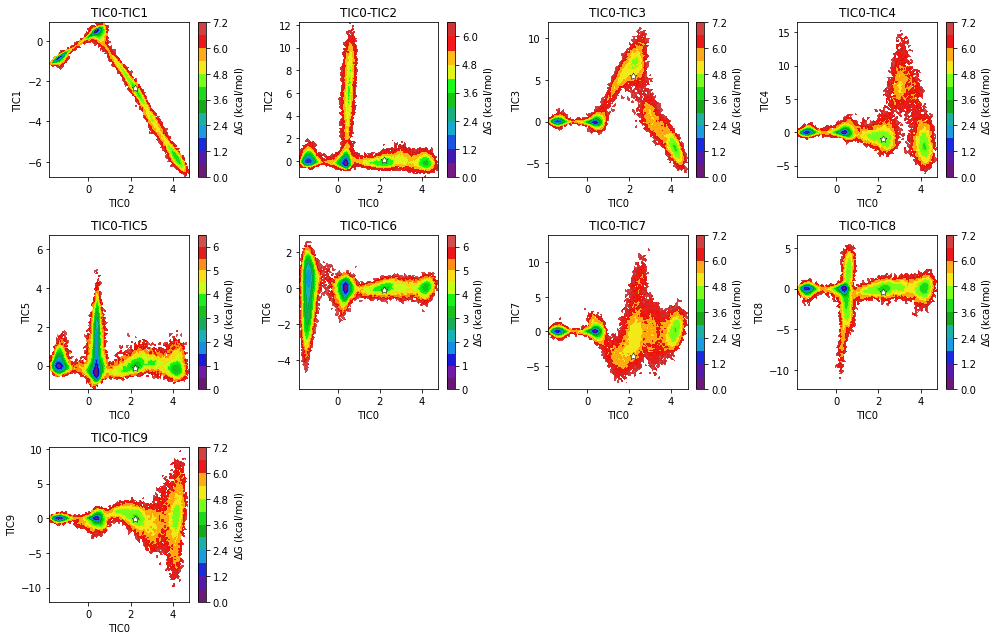

In [12]:
# Plot free energy landscapes
cols=4
rows=int(numpy.ceil((len(sel)-1)/cols))
fig,ax=plt.subplots(rows,cols,figsize=(3.5*cols,3*rows))
for i,ax_ in enumerate(ax.ravel()):
    if i+1>=len(sel):
        fig.delaxes(ax_)
        continue
    pyemma.plots.plot_free_energy(tica_cnc[:,sel[0]],tica_cnc[:,sel[i+1]],ax=ax_,cbar=True,kT=0.6,
                                  cbar_label=r"$\Delta$G (kcal/mol)",ncountours=12,alpha=0.9)
    # Plot the X-ray structure as a white star
    ax_.scatter(xry_tic[:,sel[0]],xry_tic[:,sel[i+1]],marker=(5,1),s=50,color="white",edgecolor="black",linewidths=0.5)
    ax_.set_title("TIC{}-TIC{}".format(sel[0],sel[i+1]))
    ax_.set_xlabel("TIC{}".format(sel[0]))
    ax_.set_ylabel("TIC{}".format(sel[i+1]))
fig.tight_layout()

We can see that the landscapes are relatively simple, with 4 main basins along TIC0, and then another basin along TIC2. The rest of TIC dimensions do not show clear substructures, meaning that the three first TICs will likely contain all relevant conformations (but these may be not enough to correctly describe interchange kinetics).

Curiously, the star representing the X-ray structure does not fall in one of the two most populated (blue) basins. In fact, it falls in a region of relatively high energy (TIC0$\approx$2), related with the third structure shown in __Figure2__. Let's plot each trajectory on top of the first 4 maps to have insights about this observation. We will represent each snapshot as a colored dot, from black to yellow as time increases (i.e. black dots = 0 ns and yellow dots = 1000 ns).

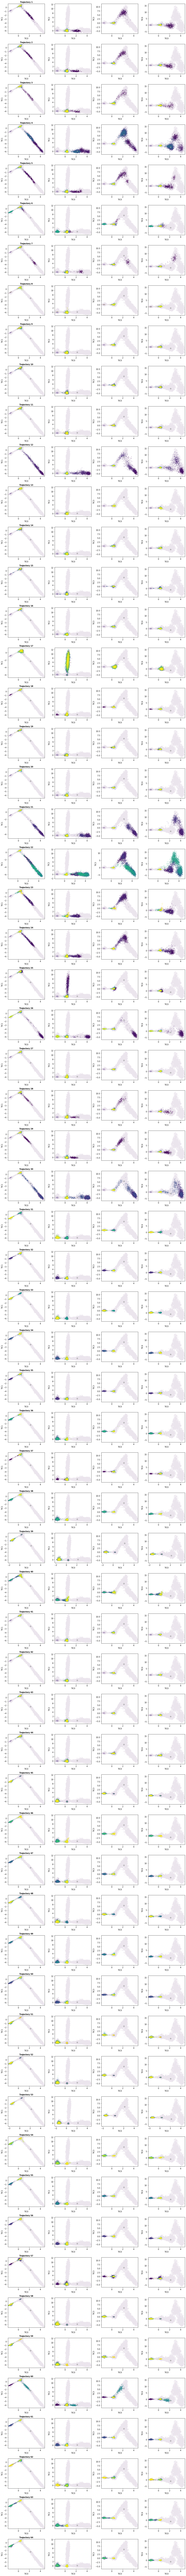

In [13]:
# Plot trajectories on top of the first TIC maps
cols=4
fig,ax=plt.subplots(len(fls),cols,figsize=(3.5*cols,3*len(fls)))
for i,tra in enumerate(fls):
    ax[i,0].set_title("Trajectory {}".format(i+1),size=10,fontweight="bold")
    for j in range(cols):
        pyemma.plots.plot_density(tica_cnc[:,sel[0]],tica_cnc[:,sel[j+1]],ax=ax[i,j],cbar=False,alpha=0.1)
        # Plot trajectories as small dots
        ax[i,j].scatter(tica_out[i][:,sel[0]],tica_out[i][:,sel[j+1]],s=0.5,c=numpy.linspace(0,1,len(tica_out[i])))
        # Plot the X-ray structure as a white star
        ax[i,j].scatter(xry_tic[:,sel[0]],xry_tic[:,sel[j+1]],marker=(5,1),s=50,color="white",edgecolor="black",linewidths=0.5)
        ax[i,j].set_xlabel("TIC{}".format(sel[0]))
        ax[i,j].set_ylabel("TIC{}".format(sel[j+1]))
fig.tight_layout()

The first 4 trajectories show how we start in the crystallographic basin (TIC0$\approx$2) and we rapidly evolve towards the central basin (TIC0$\approx$0). According to __Figure2__, this conformational change corresponds to a wrapping of the upper part of the ZA-loop. This rapid conformational change was already reported and characterized in a published work in 2017 [[Heinzelmann]](https://pubs.acs.org/doi/abs/10.1021/acs.jctc.7b00275), in which the authors found that the crystallographic state is only stable when a drug molecule is bound in the binding pocket.

More importantly, these plots show many transitions from the central basin at TIC0$\approx$0 (closed state) to the basin at the left, at TIC0$\approx$-2 (open state). Trajectories 6, 18, 26, 31, 32, 33 and 34, as well as many others, show clear transitions. Therefore, it seems that this particular process is very well sampled. In all, we conclude that taking 3-6 dimensions may be a good choice to capture the slow dynamics of the system, and thus we can remove the rest of components from memory.

In [14]:
# Select the first six components
sel=[i for i in range(6)]

# Reduced set of TICS
tica_out=[tic[:,sel] for tic in tica_out]
tica_cnc=numpy.concatenate(tica_out)
print("Trajectories: {} Dimension: {}".format(len(tica_out),len(tica_out[0][0])))

Trajectories: 64 Dimension: 6


---
#### 4. Clustering the data

Now that we have reduced the dimensionality of our data (from 1081 to 6) we can proceed with the clustering/discretization of the conformational space. Each cluster center will represent a state in our Markov model, i.e. a point from which we will compute transitions to other points in space. Among the different clustering methods implemented in PyEMMA, we will use the K-means clustering algorithm.

To estimate an appropiate number of clusters centers, we can also use the VAMP-2 score. Generally, the more cluster centers, the lower discretization error will be, however, conversely we increase the potential statistical error.

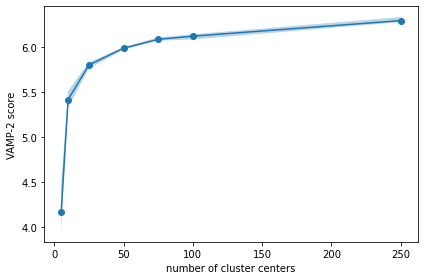

In [15]:
# Select number replicas and cluster centers
replicas,stride=5,10
n_clusters=[5,10,25,50,75,100,250]

# Here, for each nº of clusters we do N rounds of clustering and MSM estimation to obtain a VAMP-2 score.
# Note that we clusterize again for each replica to take into account the stochastic nature of the
# clustering method.
scores=numpy.zeros((len(n_clusters),replicas))
for i,k in enumerate(n_clusters):
    for j in range(replicas):
        # Clusterize the data
        _cluster=deeptime.clustering.KMeans(k,max_iter=int(numpy.sqrt(tica_cnc.shape[0])))
        _cluster=_cluster.fit(tica_cnc[::stride]).fetch_model()
        _dtrajs=[_cluster.transform(traj) for traj in tica_out]
        
         # Build count matrix; test different lags here
        _counts=deeptime.markov.TransitionCountEstimator(100,'sliding').fit(_dtrajs).fetch_model()
        _counts=_counts.submodel_largest()
        
        # Build a maximum likelihood MSM and get the VAMP-2 score
        _msm=deeptime.markov.msm.MaximumLikelihoodMSM().fit(_counts).fetch_model()
        scores[i,j]=_msm.score(_dtrajs,r=2,dim=min(10,k))

# Plot the VAMP-2 score vs the nº of cluster centers
fig,ax=plt.subplots()
lower,upper=pyemma.util.statistics.confidence_interval(scores.T.tolist(),conf=0.95)
ax.fill_between(n_clusters,lower,upper,alpha=0.3)
ax.plot(n_clusters,numpy.mean(scores,axis=1),"-o")
ax.set_xlabel("number of cluster centers")
ax.set_ylabel("VAMP-2 score")
fig.tight_layout()

From the plot we can see that above 25 cluster centers the VAMP-2 score reaches a plateau. Let's therefore select then 25 for the subsequent steps.

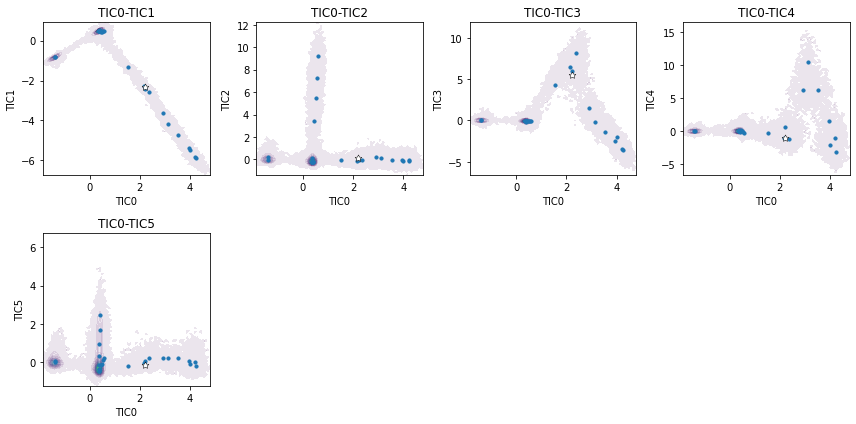

In [16]:
# k-means clustering with 25 centers
km=deeptime.clustering.KMeans(25,max_iter=int(numpy.sqrt(tica_cnc.shape[0])))
km=km.fit(tica_cnc).fetch_model()

# Discretize trajectories
dtrajs=[km.transform(tra) for tra in tica_out]

# Plot cluster centers on TIC maps
cols=4
rows=int(numpy.ceil((len(sel)-1)/cols))
fig,ax=plt.subplots(rows,cols,figsize=(3*cols,3*rows))
for i,ax_ in enumerate(ax.ravel()):
    if i+1>=len(sel):
        fig.delaxes(ax_)
        continue
    pyemma.plots.plot_density(tica_cnc[:,0],tica_cnc[:,i+1],ax=ax_,cbar=False,alpha=0.1)
    # Plot clusters as blue dots
    ax_.scatter(km.cluster_centers[:,0],km.cluster_centers[:,i+1],c="C0",s=10)
    # Plot the X-ray structure as a white star
    ax_.scatter(xry_tic[:,sel[0]],xry_tic[:,sel[i+1]],marker=(5,1),s=50,color="white",edgecolor="black",linewidths=0.5)
    ax_.set_title("TIC{}-TIC{}".format(sel[0],sel[i+1]))
    ax_.set_xlabel("TIC{}".format(sel[0]))
    ax_.set_ylabel("TIC{}".format(sel[i+1]))
fig.tight_layout()

They look well distributed over the space. Now we are prepared to discretize the trajectories and build a Markov state model.

---
#### 5. Markov state model estimation and validation

At this point we can build a Markov state model using the discretized trajectories from the clustering object. Let's start by computing the implied timescales at different lagtimes, because these should be independent of any modelling parameter. Again, lagtimes should be comprised between 0 and 1000 ns. We will plot the first 5 implied timescales (nits) according to the following relation:
$$ \text{ITS}_i = -\frac{\tau}{\log|\lambda_i|}$$
where $\tau$ is the lag-time and $\lambda_i$ is the $i$'th eigenvalue.

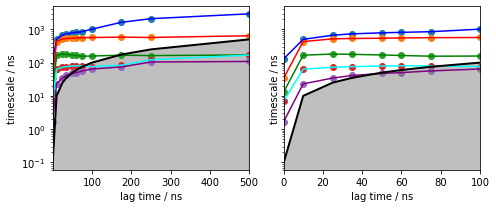

In [17]:
# Test lagtimes between 1 and 5000 steps; get 5 implied timescales
nits,lags=5,numpy.array([1,100,250,350,500,600,750,1000,1750,2500,5000])

timescales,msms=[],[]
for lag in lags:
    # Build the count matrix
    counts_estimator=deeptime.markov.TransitionCountEstimator(lag,"sliding")
    counts=counts_estimator.fit(dtrajs).fetch_model()
    counts=counts.submodel_largest()

    # Build a maximum likelihood MSM and get the first 5 timescales
    msm=deeptime.markov.msm.MaximumLikelihoodMSM().fit(counts).fetch_model()
    timescales.append(msm.timescales(k=nits))
    msms.append(msm)

# Plot timescales
fig,ax=plt.subplots(1,2,figsize=(3.5*2,3),sharey=True)
pyemma.plots.plot_implied_timescales((lags,timescales),dt=stept,ax=ax[0],units="ns",xlog=False,ylog=True);
for i in range(nits):
    ax[0].scatter(numpy.array(lags)*stept,[t[i]*stept for t in timescales])
    ax[1].scatter(numpy.array(lags)*stept,[t[i]*stept for t in timescales])
# Same plot but zoom in the 0-100 region
pyemma.plots.plot_implied_timescales((lags,timescales),dt=stept,ax=ax[1],units="ns",xlog=False,ylog=True)
ax[1].set_xlim(0,100)
fig.tight_layout()

Note that the warning tells us that, of course, one can not compute an MSM with a lagtime equal or greather than the longest trajectory. From the plot we can see the five requested timescales/processes. The slowest one (blue) is clearly diverging at long lagtimes (not converged), but looks reasonable between 0 and 100 ns.

The other four processes look generally flat and converged from lagtimes above 25 ns (250 steps). Note that the green, cyan and violet processes decay rapidly and can not be resolved above 100 ns. Let's build a MSM with a lag of 50 ns to see if we can characterize at least the first four.

In [18]:
# Build the count matrix; note that here we switch to "effective" count mode
# because we intend to build a Bayesian MSM.
count_estimator=deeptime.markov.TransitionCountEstimator(lagtime=500,count_mode='effective')
counts=count_estimator.fit(dtrajs).fetch_model()
counts=counts.submodel_largest()
print("Active state fraction: {:1.2f}".format(counts.selected_count_fraction))

# Build a bayesian MSM with 100 samples.
bayesian_msm_estimator=deeptime.markov.msm.BayesianMSM(n_samples=100)
bayesian_msm=bayesian_msm_estimator.fit(counts).fetch_model()

Active state fraction: 1.00


An active state fraction of 1 indicates that the model considers all 25 cluster centers, it has not excluded points due to low connectivities. Let's plot the timescales of this particular model:

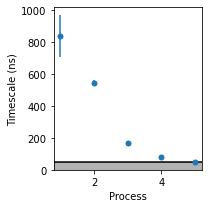

In [19]:
# Gather statistics of timescales from the 100 Bayesian samples.
stats=bayesian_msm.gather_stats('timescales',k=nits)

# Plot timescale separation
fig,ax=plt.subplots(figsize=(3,3))
ax.errorbar(range(1,nits+1),stats.mean*stept,yerr=stats.std*stept,fmt=".",markersize=10)
ax.axhline(count_estimator.lagtime*stept,lw=1.5,color="k")
ax.axhspan(0,count_estimator.lagtime*stept,alpha=0.3,color="k")
ax.set_xlabel("Process")
ax.set_ylabel("Timescale (ns)")
ax.set_ylim(bottom=0)
fig.tight_layout()

The plot above shows 4 processes above the threshold (50 ns), with the first one having a high uncertainty, and the fourth being nearly at the limit of model's resolution. With 3-4 processes we can resolve up to 4-5 metastable states. Let's then coarse grain our 25 state model to 4 states using the PCCA++ algorithm. The PCCA++ algorithm groups together Markov states into a predefined number of metastable states based upon the eigenvalues and eigenvectors of the MSM. We use these metastable state definitions to compute populations and mean first-passage times (MFPT) between them.

In [20]:
# Coarse grain the model with PCCA++
nstates=4
pcca=bayesian_msm.prior.pcca(nstates)

# Compute MFPTs
mfpt=[]
for i in range(pcca.n_metastable):
    mfpt.append([])
    for j in range(pcca.n_metastable):
        if i!=j:
            # Mean, std, and confidence intervals over the 100 Bayesian samples
            stats=bayesian_msm.gather_stats('mfpt',A=pcca.sets[i],B=pcca.sets[j])
            mfpt[i].append(r"{:1.1f} $\pm$ {:1.1f}  [{:1.1f}|{:1.1f}]".format(stats.mean,stats.std,
                                                                              stats.L,stats.R))
        else:
            mfpt[i].append("")

# Compute populations with CRISP partition
cpop=numpy.round([bayesian_msm.prior.stationary_distribution[state].sum() for state in pcca.sets],2)
         
# Compute populations with memberships
mpop=numpy.round([(bayesian_msm.prior.stationary_distribution*state).sum() for state in pcca.memberships.T],2)

# Plot dataframes side by side
df1=pandas.DataFrame(cpop,index=["State {}".format(i) for i in range(pcca.n_metastable)],
                     columns=[r"$\pi$$_{crisp}$"]).to_html()
df2=pandas.DataFrame(mpop,index=["" for i in range(pcca.n_metastable)],
                     columns=[r"$\pi$$_{memb}$"]).to_html()
df3=pandas.DataFrame(mfpt,index=["" for i in range(pcca.n_metastable)],
                     columns=[r"state$\to${} (ns)".format(i) for i in range(pcca.n_metastable)]).to_html()
display_html((df1+df2+df3).replace("table","table style='display:inline'"),raw=True)

$\pi$$_{crisp}$ 
 
 
 
 
 State 0 
 0.00 
 
 
 State 1 
 0.00 
 
 
 State 2 
 0.10 
 
 
 State 3 
 0.89 
 
 
 
 
 
 
 $\pi$$_{memb}$ 
 
 
 
 
 
 0.00 
 
 
 
 0.00 
 
 
 
 0.12 
 
 
 
 0.87 
 
 
 
 
 
 
 state$\to$0 (ns) 
 state$\to$1 (ns) 
 state$\to$2 (ns) 
 state$\to$3 (ns) 
 
 
 
 
 
 
 1875417.3 $\pm$ 345827.5 [1427192.9|3146358.0] 
 57178.5 $\pm$ 2464.4 [51985.5|61930.0] 
 1459.3 $\pm$ 91.7 [1328.1|1647.6] 
 
 
 
 5483159.1 $\pm$ 1440434.9 [3559013.6|10514866.7] 
 
 63157.3 $\pm$ 2668.1 [57828.0|68485.7] 
 8691.6 $\pm$ 1334.2 [6363.6|12357.6] 
 
 
 
 5480871.8 $\pm$ 1440274.1 [3556074.4|10512208.9] 
 1879093.8 $\pm$ 345752.8 [1430596.0|3045392.0] 
 
 6380.3 $\pm$ 198.8 [5982.4|6708.4] 
 
 
 
 5473901.6 $\pm$ 1440281.4 [3549208.5|10505544.5] 
 1873170.4 $\pm$ 345808.5 [1425067.4|2569964.5] 
 54901.0 $\pm$ 2478.0 [49722.2|59653.9]

We see a good agreement between the CRISP and Membership partitions. State 3 is the most populated one, with a weight of nearly 0.9, and state 2 is taking the rest (0.1). States 0 and 1 are very minor ($\pi$$<$0.01). Let's check how this differs from the empirical populations.

In [21]:
# Metastable (coarse-grained) trajectories
active_traj=numpy.array([bayesian_msm.prior.count_model.transform_discrete_trajectories_to_submodel(tra) for tra in dtrajs])
active_traj_cnc=numpy.concatenate(active_traj)
metastable_traj=pcca.assignments[active_traj_cnc[active_traj_cnc!=-1]]

# Print empirical populations
ssize=[]
for i in range(pcca.n_metastable):
    ssize.append((metastable_traj==i).mean())
    print("State {}: {:1.2f}".format(i,(metastable_traj==i).mean()))
ssize=numpy.array(ssize)

State 0: 0.01
State 1: 0.02
State 2: 0.26
State 3: 0.71


They are qualitatively the same, but there are quantitative differences. The empirical populations give more predominance to state 2 (0.26 vs 0.1) since we started several simulations from there, but the MSM reweighting is able to restore the predominance of State 3. Let's check now if these populations are converged across different lagtimes:

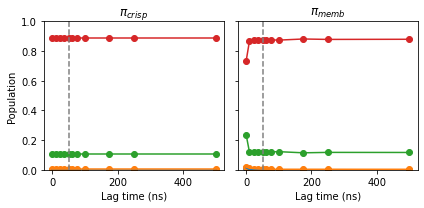

In [22]:
# Here we take the MSMs from the ITS cell and compute populations both with
# CRISP and fuzzy memberships using the MSM metastable state definitions.
pop=numpy.zeros((len(msms),2,pcca.n_metastable))
active_set=bayesian_msm.prior.state_symbols()
for i,model in enumerate(msms):
    # CRISP partition
    cset=[numpy.isin(active_set,active_set[m]) for m in pcca.sets]
    pop[i,0,:]=[bayesian_msm.prior.stationary_distribution[s].sum() for s in cset]
    
    # Memberships
    mset=numpy.isin(active_set,model.state_symbols())
    pop[i,1,:]=[(model.stationary_distribution[numpy.isin(model.state_symbols(),active_set)]*state).sum() for state in pcca.memberships[mset,:].T]
    # If MSM active set < Model active set reweight
    if len(model.state_symbols())>len(active_set):
        for j in range(2):
            pop[i,j,:]=pop[i,j,:]/pop[i,j,:].sum()
        print("Model {} reweighted.".format(i))

# Plot convergence of populations vs lag time
title=[r"$\pi$$_{crisp}$",r"$\pi$$_{memb}$"]
fig,ax=plt.subplots(1,2,figsize=(3*2,3),sharey=True)
for i in range(2):
    ax[i].plot(lags*stept,pop[:,i,:])
    for j in range(pcca.n_metastable):
        ax[i].scatter(lags*stept,pop[:,i,j])
    ax[i].set_ylim((0,1))
    ax[i].axvline(bayesian_msm.prior.lagtime*stept,color="gray",linestyle="--")
    ax[i].set_xlabel("Lag time (ns)")
    ax[i].set_title(title[i])
ax[0].set_ylabel("Population")
fig.tight_layout()

Again, we see a very good agreement between CRISP and Membership partitions, and all state populations are well converged along lagtimes. Let's see now how the metastable states look on the FELs:

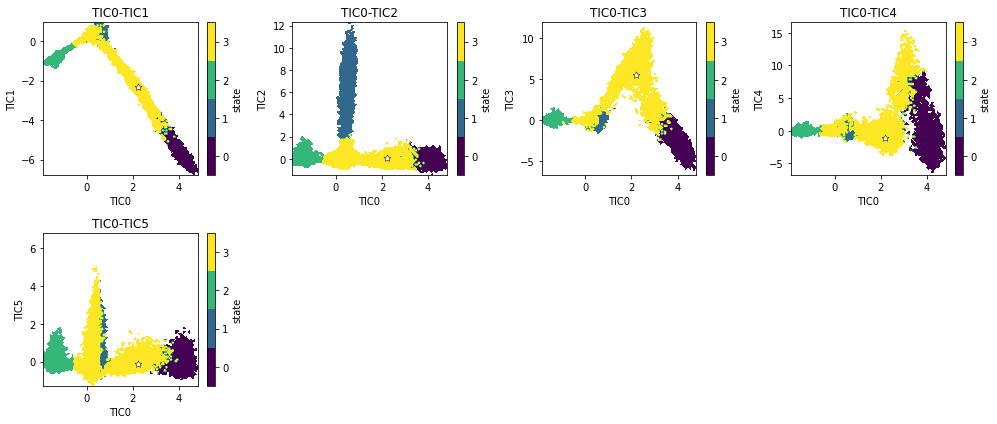

In [23]:
# Plot state maps
cols=4
rows=int(numpy.ceil((len(sel)-1)/cols))
fig,ax=plt.subplots(rows,cols,figsize=(3.5*cols,3*rows))
for i,ax_ in enumerate(ax.ravel()):
    if i+1>=len(sel):
        fig.delaxes(ax_)
        continue
    # Note active_traj!=-1 avoids counting the last value of the vector for non-active states
    pyemma.plots.plot_state_map(tica_cnc[active_traj_cnc!=-1,0],tica_cnc[active_traj_cnc!=-1,i+1],metastable_traj,ax=ax_)
    # Plot the X-ray structure as a white star
    ax_.scatter(xry_tic[:,sel[0]],xry_tic[:,sel[i+1]],marker=(5,1),s=50,color="white",edgecolor="black",linewidths=0.5)
    ax_.set_title("TIC{}-TIC{}".format(sel[0],sel[i+1]))
    ax_.set_xlabel("TIC{}".format(sel[0]))
    ax_.set_ylabel("TIC{}".format(sel[i+1]))
fig.tight_layout()

The separation is very clean. We can clearly see that the central basin (yellow, TIC0 between 0 and 2; X-ray like) corresponds to state 3, with nearly 0.9 population, and the basin at the left (green, TIC0$\approx$-2; open state) corresponds to state 2, with 0.1 population. We will look at their structures below.

First, let's check how do the right eigenvectors look on top of the FELs. These eigenvectors give us an idea of how the processes evolve/change along our defined space. This will allow us to identify which metastable states are involved in a given process.

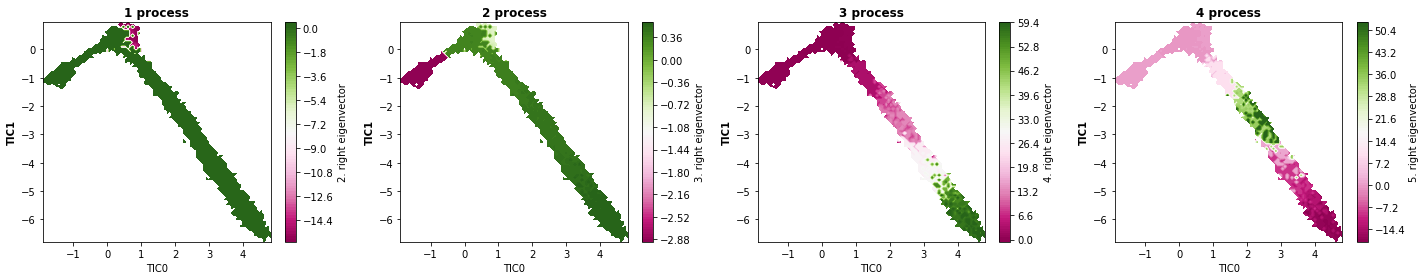

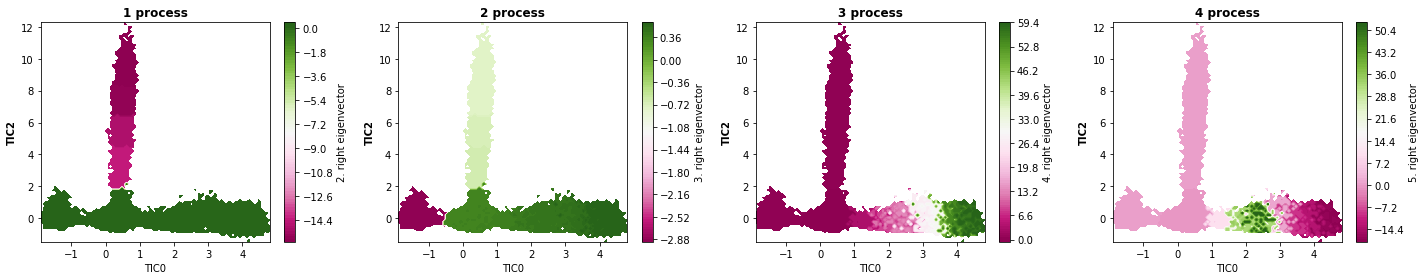

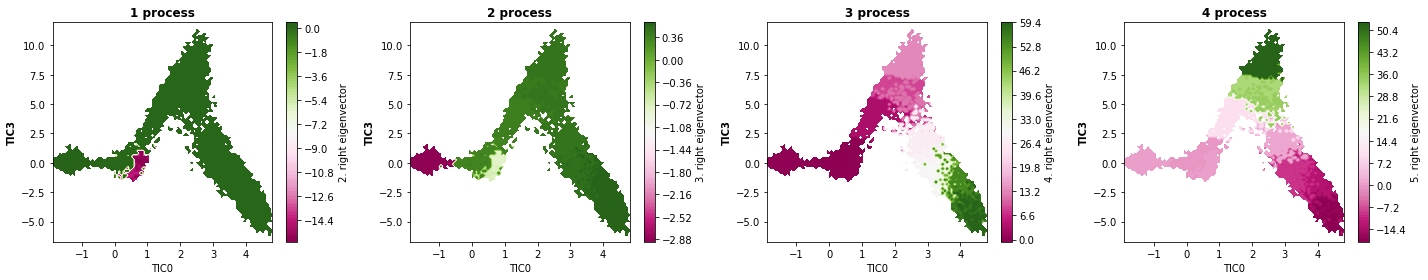

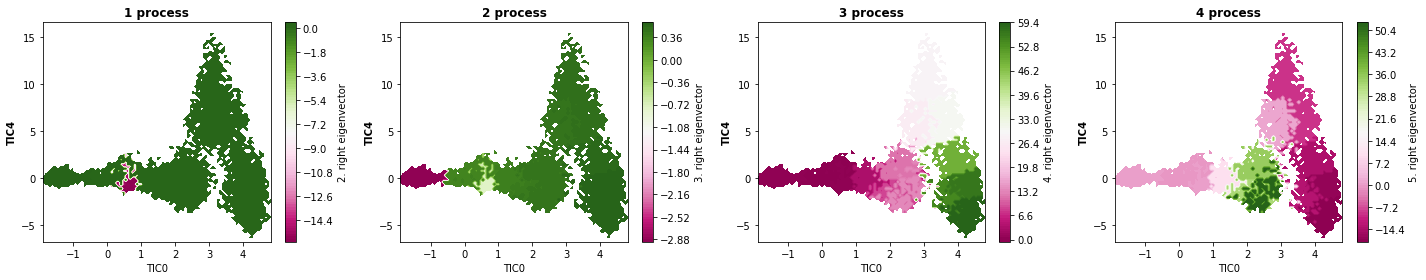

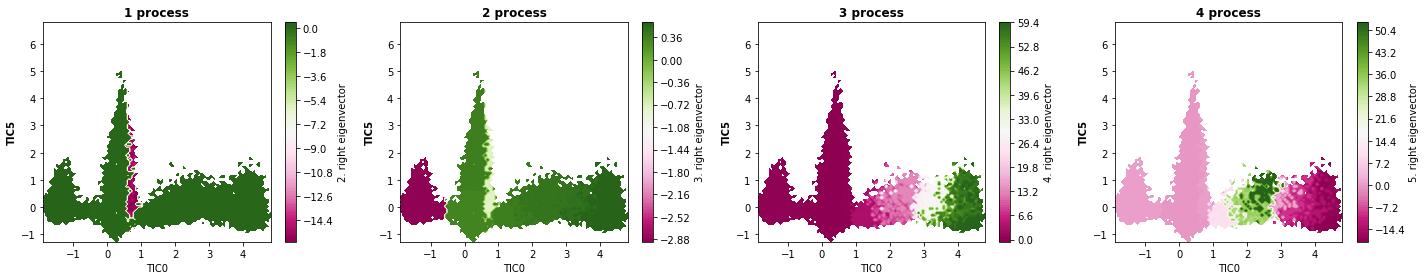

In [24]:
# Plot the first 4 right eigenvectors to visualize each process
eigvec=bayesian_msm.prior.eigenvectors_right()

for i in range(len(sel)-1):
    fig,ax=plt.subplots(1,4,figsize=(5*4,4))
    for j in range(4):
        # Note active_traj!=-1 avoids counting the last value of the vector for non-active states
        pyemma.plots.plot_contour(tica_cnc[active_traj_cnc!=-1,0],tica_cnc[active_traj_cnc!=-1,i+1],eigvec[active_traj_cnc[active_traj_cnc!=-1],j+1],ax=ax[j],
                                  cmap='PiYG',cbar_label='{}. right eigenvector'.format(j+2),mask=True)
        ax[j].set_title("{} process".format(j+1),weight="bold")
        ax[j].set_xlabel("TIC{}".format(sel[0]))
        ax[j].set_ylabel("TIC{}".format(sel[i+1]),weight="bold")
    fig.tight_layout()

If we look at the 1rst process in the TIC0-TIC2 map, we see that it involves a transition along TIC2, between the basin at the top (state 1 according to the state map plots given above) and the two basins below (open and X-ray like states). This process corresponds to the slowest timescale, i.e. the one that is diverging at long timescales in the ITS plot.

The second process involves a transition along TIC0 and can be clearly seen in any map. It involves a transition from the left basin (open state) to the basins at the right (the X-ray like closed states). In other words, __the second process corresponds to the ZA-loop opening__. This is precisely the one that is well converged in the ITS plot, and the one that according to our trajectory plots is very well sampled. We can see this clearly plotting a network with the count matrix:

[[   342.170      0.000      0.000    197.570]
 [     0.000    598.420      0.170     35.240]
 [     0.000      0.210  10272.900    879.220]
 [    86.280     25.210    666.550  64802.920]]


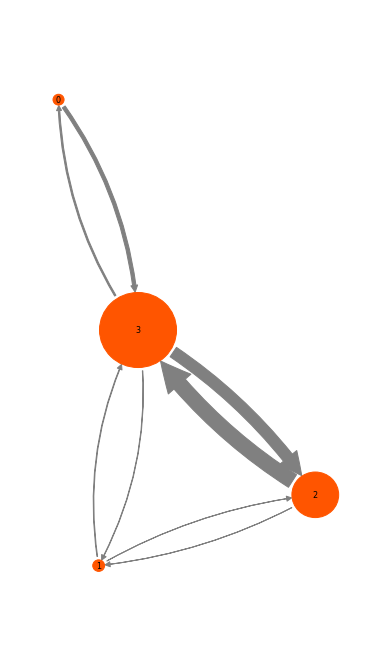

In [25]:
# Compute count matrix
numpy.set_printoptions(formatter={'float': lambda x: "{:10.3f}".format(x)})

mat=numpy.zeros((pcca.n_metastable,pcca.n_metastable))
for i,m in enumerate(pcca.sets):
    for j,n in enumerate(pcca.sets):
        mat[i,j]=counts.count_matrix[m,:][:,n].sum()
print(mat.round(2).astype(float))

# Plot network with counts
pyemma.plots.plot_network(mat,state_sizes=ssize,arrow_label_format='',arrow_labels=mat,arrow_scale=3.0,size=8);

This network shows how state 3 (X-ray like) is the most populated and the one that is connected to all other states. It exchanges mostly with state 2 (open state), consistent with the many transitions we observed in the trajectory plots above.

Finally, we will do a last convergence test to see if our model is (kinetically) self-consistent with the data we used to generate it. We will test the Champan-Kolmogorov property:

$$ \mathbf{P}(k \tau) = \mathbf{P}^k(\tau) $$

with $\mathbf{P}(\tau)$ being the transition probability matrix and $\tau$ the lagtime. We will propagate the model $k$ times (10 by default).

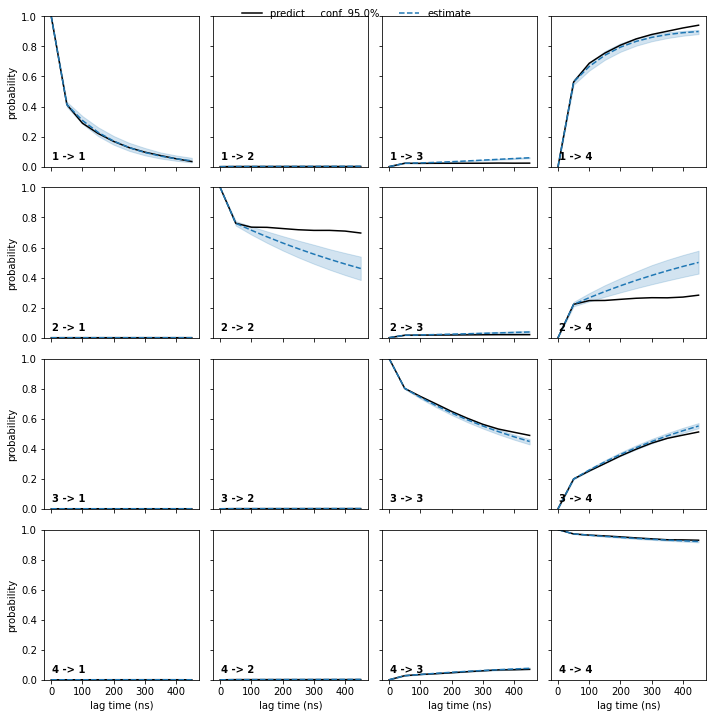

In [26]:
# Compute and plot a CKtest
cktest=bayesian_msm_estimator.chapman_kolmogorov_validator(pcca.n_metastable,10).fit_fetch(dtrajs)
fig,ax=pyemma.plots.plot_cktest(cktest,diag=False,dt=stept,units="ns")
fig.tight_layout()

Overall, we see an excellent agreement between our estimates and predictions. The only exception is state 2 (state 1 with 0-indexing!), which corresponds to the slowest process, the one that is not converged according to the ITS plot. This happens because state 2 is poorly explored, and the connectivity with the rest of the basins may be artificial, arising from discretization and projection errors. Let's see which trajectories visit this metastable state:

In [27]:
# Check which trajectories visit metastable state 1 (0-indexing)
state=1
for i,tra in enumerate(active_traj):
    count=sum([list(tra).count(c) for c in pcca.sets[state]])
    if count>0:
        print("Trajectory {}: {}".format(i+1,count))

Trajectory 1: 1
Trajectory 6: 1
Trajectory 8: 3
Trajectory 10: 1
Trajectory 17: 9894
Trajectory 18: 1
Trajectory 23: 1
Trajectory 25: 820
Trajectory 28: 1
Trajectory 34: 1
Trajectory 40: 5
Trajectory 52: 1
Trajectory 57: 1
Trajectory 59: 1


Only trajectories 17 and 25 are sampling state 1 substantially, as we can see in the following plot:

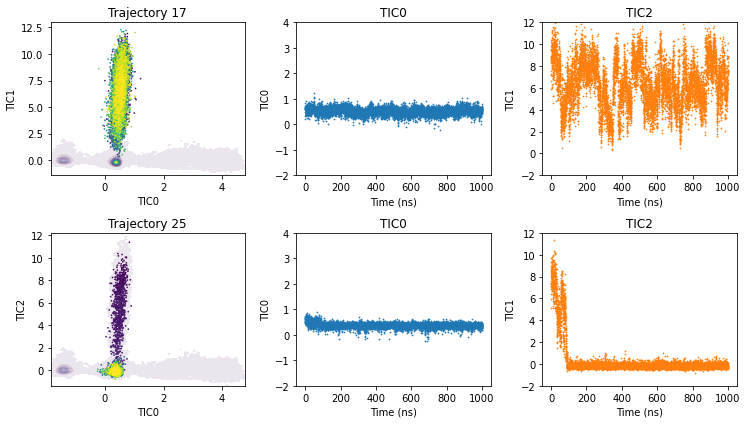

In [28]:
# Plot trajectories related to state 2 (1 with 0-indexing)
fig,ax=plt.subplots(2,3,figsize=(3.5*3,3*2))
for i,j in enumerate([17,25]):
    ptime=[k*stept for k in range(tica_out[j-1].shape[0])]
    ax[i,0].set_title("Trajectory {}".format(j),size=12)
    pyemma.plots.plot_density(tica_cnc[:,0],tica_cnc[:,2],ax=ax[i,0],cbar=False,alpha=0.1)
    ax[i,0].scatter(tica_out[j-1][:,0],tica_out[j-1][:,2],s=0.5,c=numpy.linspace(0,1,len(tica_out[j-1])))
    ax[i,1].set_title("TIC0",size=12)
    ax[i,1].set_ylim([-2.0,4.0])
    ax[i,1].scatter(ptime,tica_out[j-1][:,0],s=0.5)
    ax[i,2].set_title("TIC2",size=12)
    ax[i,2].set_ylim([-2.0,12.0])
    ax[i,2].scatter(ptime,tica_out[j-1][:,2],s=0.5,c="C1")
    for k in range(2):
        ax[i,k+1].set_xlabel("Time (ns)")
        ax[i,k+1].set_ylabel("TIC{}".format(k))
        ax[i,0].set_xlabel("TIC0")
        ax[i,0].set_ylabel("TIC{}".format(i+1))
fig.tight_layout()

Indeed, we see only one transition that is not reversibly connected, and thus we can not say anything meaningful about this state. Importantly, this drawback does not affect all other states that we have resolved and validated, and therefore we can obtain useful information about their properties.

#### 6. Computing properties of interest

First we will select a subset of representative structures for each metastable state, and then compute  certain properties that are of interest, such as the solvent accessible surface area of the conserved aspartate, the free energy profiles, or the histograms and expectation values of specific interactions.

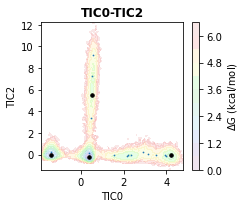

In [29]:
# Select most representative center of each metastable state according to its Pi value
select=[active_set[mset[bayesian_msm.prior.stationary_distribution[mset].argmax()]] for mset in pcca.sets]

# Plot the selected states as black dots
plot=(0,2)
fig,ax=plt.subplots(figsize=(3.5,3))
pyemma.plots.plot_free_energy(tica_cnc[:,plot[0]],tica_cnc[:,plot[1]],ax=ax,cbar=True,kT=0.6,alpha=0.1,
                              cbar_label=r"$\Delta$G (kcal/mol)",ncountours=12)
ax.scatter(km.cluster_centers[:,plot[0]],km.cluster_centers[:,plot[1]],c="C0",s=0.5)
# Black dots represent the selected representative centers
ax.scatter(km.cluster_centers[select,plot[0]],km.cluster_centers[select,plot[1]],c="black",s=12)
ax.set_title("TIC{}-TIC{}".format(plot[0],plot[1]),fontweight="bold")
ax.set_xlabel("TIC{}".format(plot[0]))
ax.set_ylabel("TIC{}".format(plot[1]))
fig.tight_layout()

In [30]:
# Save 100 representative structures in disk
samples=[]
for s in select:
    w=numpy.where((numpy.array(dtrajs)==s)==True)
    samples.append(numpy.array([i for i in zip(w[0],w[1])]))
samples=deeptime.markov.sample.indices_by_state(samples,100,replace=False)

feat_source=pyemma.coordinates.source(fls,features=feat) # source object needed to save coordinates
for i,smpl in enumerate(samples):
    pyemma.coordinates.save_trajs(feat_source,smpl,outfiles=["./structures/state{}.xtc".format(i)])
    pyemma.coordinates.save_trajs(feat_source,numpy.array([smpl[0]]),outfiles=["./structures/state{}.pdb".format(i)])
    
# Save samples in memory for other calculations (e.g. SASA)
memples=[pyemma.coordinates.save_traj(feat_source,sample,outfile=None,top=feat.topology) for sample in samples]

Obtaining file info:   0%|                               | 0/64 [00:00<?, ?it/s]

<img src="./figures/figure3.png" width="800" height="50" />

> __Figure 3-__ Representative structures of the 4 metastable states. Note that all states are closed excepting state 2 (green), in which the ZA-loop is displaced from the $\alpha$$_A$-helix.

Now that we have representative metastable states, we will compute e.g. the solvent accessible surface area of the conserved aspartate that is beneath the ZA-loop.

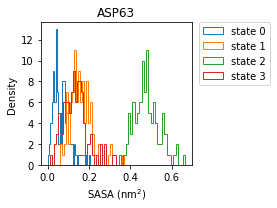

In [31]:
# Compute SASA of all residues using MDtraj
sasa=[mdtraj.shrake_rupley(sample,mode="residue") for sample in memples]

# Plot SASA of Asp63 (62 with 0-index)
fig,ax=plt.subplots(figsize=(4,3))
for i,s in enumerate(sasa):
    ax.hist(s[:,62],bins=32,label="state {}".format(i),histtype="step")
ax.set_title("{}".format(feat.topology.residue(62)))
ax.set_xlabel(r"SASA (nm$^2$)")
ax.set_ylabel("Density")
ax.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.)
fig.tight_layout()

The plot shows that in state 2 the conserved aspartate has a significantly larger SASA than in states 0, 1 and 3. This makes sense since in state 2 the ZA-loop is displaced from the $\alpha$$_A$-helix (open state) and the aspartate is exposed to the solvent (see __Figure 4__).

<img src="./figures/figure4.png" width="450" height="100" />

> __Figure 4-__ Closeup of the opening conformational change in the region of the conserved aspartate (Asp106 in the full BRD4 sequence).

Now we will use the MSM to reweight the empirical free energy profile along TIC0:

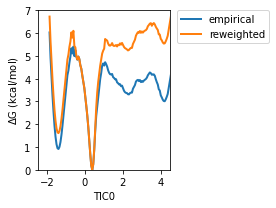

In [32]:
# Get weights
weights=bayesian_msm.prior.compute_trajectory_weights(dtrajs)

# Compute FEP with and without reweighting
fep_nr=numpy.histogram(tica_cnc[:,0],bins=128)
fep_wr=numpy.histogram(tica_cnc[:,0],bins=128,weights=numpy.concatenate(weights))

# Plot free energy profiles
fig,ax=plt.subplots(figsize=(4,3))
ax.plot((fep_nr[1][1:]+fep_nr[1][:-1])/2,[-0.6*numpy.log(x/max(fep_nr[0])) if x>0 else None for x in fep_nr[0]],
        linewidth=2,color="C0",label="empirical");
ax.plot((fep_wr[1][1:]+fep_wr[1][:-1])/2,[-0.6*numpy.log(x/max(fep_wr[0])) if x>0 else None for x in fep_wr[0]],
        linewidth=2,color="C1",label="reweighted");
ax.set_xlim(-2.5,4.5)
ax.set_ylim(0,7)
ax.set_xlabel("TIC0")
ax.set_ylabel(r"$\Delta$G (kcal/mol)")
ax.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.)
fig.tight_layout()

We can see how the reweighting increases $\Delta$G by about 1 kcal/mol in the open state basin (i.e. it is less stable than what we obtain empirically), and even more for the states above TIC0=1, in agreement with their fast transitions to the central basin.

Let's also use the MSM reweighting to see how a specific distance changes with respect to the empirical estimate. We will compute the mindist between certain backbone residues of the ZA-loop and the conserved aspartate, which can be seen as a "ZA-loop opening distance".

In [33]:
# Load ZA-loop opening distance
loop_feat=pyemma.coordinates.featurizer(pdb)
loop_feat.add_group_mindist([loop_feat.topology.select("residue 42 to 58 and backbone"),loop_feat.topology.select("residue 63")],periodic=False)
loop_data=pyemma.coordinates.load(fls,features=loop_feat)
loop_cnc=numpy.concatenate(loop_data)
print(loop_feat.describe())

/srv/public/miniconda3/envs/tutorial/lib/python3.8/site-packages/pyemma/coordinates/data/featurization/distances.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.group_definitions = np.array(group_definitions)


Obtaining file info:   0%|                               | 0/64 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|                   | 0/64 [00:00<?, ?it/s]

['GROUP_MINDIST 0--1: [GLN 42 N 708...ILE 58 O 994]--[ASP 63 N 1062...ASP 63 O 1073]']


 Empirical: 0.27
Reweighted: 0.11


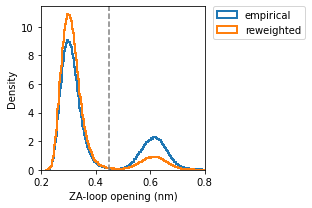

In [34]:
fig,ax=plt.subplots(figsize=(4.5,3))
ax.hist(loop_cnc,bins=264,density=True,histtype="step",linewidth=2,color="C0",label="empirical");
ax.hist(loop_cnc,bins=264,density=True,histtype="step",linewidth=2,color="C1",label="reweighted",weights=numpy.concatenate(weights));
ax.axvline(0.45,ls="--",c="gray")
ax.set_xlim(0.2,0.8)
ax.set_xlabel("ZA-loop opening (nm)")
ax.set_ylabel("Density")
ax.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.)
fig.tight_layout()

print(" Empirical: {:1.2f}".format((loop_cnc>0.45).mean()))
print("Reweighted: {:1.2f}".format(((loop_cnc>0.45)[:,0]*numpy.concatenate(weights)).sum()))

Here, as it happens with the free energy profile above, we also observe a large influence of the reweighting. This is because we started several simulations from the open basin (the one at $\approx$0.6 nm), and the empirical population is larger than the one that is obtained when leveraging the kinetic information. Note that we have applied an arbitrary threshold (0.45 nm) based on the histograms, but we can directly compute populations using the metastable state definitions:

In [35]:
print(" Empirical: {:1.2f}".format((metastable_traj==2).mean()))
print("Reweighted: {:1.2f}".format(((metastable_traj==2)*numpy.concatenate(weights)).sum()))

 Empirical: 0.26
Reweighted: 0.10


We can also compute expectation values from the mean values of each Markov state:

In [36]:
# Expectation value
sv=[loop_cnc[active_traj_cnc==i].mean() for i in range(bayesian_msm.prior.n_states)]
print("Expectation: {:1.2f} (nm)".format(bayesian_msm.prior.expectation(sv)))

Expectation: 0.34 (nm)


If we plot the ZA-loop opening distance on the FEL maps, we can also see a good agreement between open regions (red) and the metastable separation for state 2 (open) shown in the state maps above.

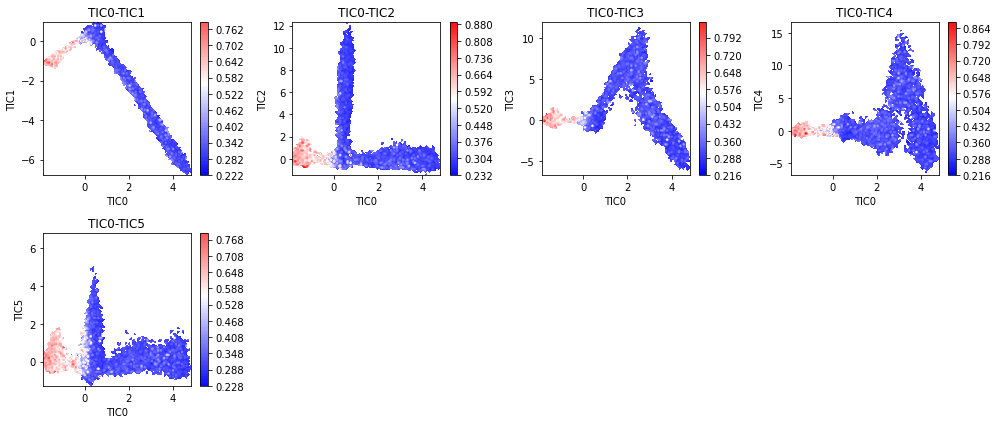

In [37]:
# Plot ZA-loop opening on top of the FELs
cols=4
num=int(numpy.ceil((len(sel)-1)/cols))
fig,ax=plt.subplots(num,cols,figsize=(3.5*cols,3*num))
for i,ax_ in enumerate(ax.ravel()):
    if i+1>=len(sel):
        fig.delaxes(ax_)
        continue
    pyemma.plots.plot_contour(tica_cnc[active_traj_cnc!=-1,0],tica_cnc[active_traj_cnc!=-1,i+1],loop_cnc[active_traj_cnc!=-1,0],
                              ax=ax_,mask=True,cmap="bwr")
    ax_.set_title("TIC{}-TIC{}".format(sel[0],sel[i+1]))
    ax_.set_xlabel("TIC{}".format(sel[0]))
    ax_.set_ylabel("TIC{}".format(sel[i+1]))
fig.tight_layout()

Finally, we will save our models to disk so that we can use them another time:

In [38]:
# Save models
with open("./models/brd4-cluster.pkl",'wb') as f:
    pickle.dump(km,f)
with open('./models/brd4-tica.pkl','wb') as f:
    pickle.dump(tica,f)
with open('./models/brd4-bayesian_msm.pkl','wb') as f:
    pickle.dump(bayesian_msm,f)

---
### Final remarks and pieces of advice
---
In this notebook, we used PyEMMA to build and validate an MSM of a complex biological system. In particular, we have shown how to resolve a slow conformational change in which the ZA-loop of BRD4(1) displaces from the $\alpha_A$-helix, opening a pocket beneath it. Along with the modeling steps, we have seen how to tune different hyper-parameters (both systematically and visually) and identify states that are not resolved adequately by our model. Here below, we summarize and highlight the most important points to remember:

__1. Feature selection:__ This is probably the most critical task to optimize and can also be the most difficult. A model can not resolve what is not described by the features. Still, on the other hand, if features describe too many processes, our data will likely be insufficient to resolve them quantitatively. The best option is to try several different selections, going from high complexity to trivial descriptors, and compare the final results to see if they are generally consistent.

> In this example, we started with CA-CA pairwise distances of a particular region, but we can use other features to describe the same opening process. Try, for instance, using XYZ coordinates and backbone dihedrals of the same residues, as well as using only the two hydrogen bond distances shown in Figure 1a. See also what happens if you include the flexible N-terminus in the CA-CA pairwise selection ("resid 0 to 70 and name CA").


__2. Dimensionality reduction:__ this is an essential step when our feature space is very large. Either TICA or VAMP methods are good choices for this task. We can further use VAMP to score different selections of lagtime and dimensions. However, in practice, visual inspection of e.g., the substructure of TICs is more effective as we save computer time and gain comprehension about the system. One can start by building a TICA with a low lagtime to identify potentially interesting states (even if they belong to fast processes) and later tune this parameter accordingly.

> Try plotting FEL of TICs obtained with lagtimes of 100, 500, and 750 ns. Compare them with the TICs obtained at a lag time of 10 ns. You may see that the basins corresponding to fast processes collapse with neighbor basins, hiding them above a certain threshold. This collapse is fine as soon as we are not interested in those fast processes since the FELs become simpler.


__3. Data visualization:__ This point in the general protocol helps identify states of interest and detect possible lacks in our data before building the final MSM. For instance, by visualizing trajectories on top of the FELs, we observed a rapid reshaping of the ZA-loop in the crystallographic state and several transitions between the open and closed states. Most importantly, these plots also help to detect badly sampled or disconnected processes, such as the one related to state 2 (trajectories 17 and 25). If we observe highly disconnected states, it can be beneficial to exclude trajectories going to these states and redo the TICA to have a more nuanced representation of the active space.

> Remove the two trajectories related to state 2 (nº 17 and 25) and build a new MSM from scratch. The slow process that was diverging at long lag times will not appear anymore, and you will be able to coarse grain the final model into two states (open and closed).


__4. Clustering the data:__ a good discretization of the state space is essential to obtain a reliable MSM and subsequently identify all metastable states. A bad discretization may lead to the loss of kinetic processes and the introduction of fictitious counts in the transition probability matrix. Here we used the K-means algorithm to discretize the 6-dimensional space and the VAMP-2 score to select the optimal number of clusters. Generally, one can circumvent discretization problems by increasing the number of clusters at the expense of computational efforts and statistical errors. However, in practice, for some systems like the one analyzed here, one can resolve processes of interest even with a single cluster center per basin, obtaining meaningful populations and reasonable kinetics.

> Try using only two cluster centers to resolve the opening process in the 6-dimensional space. Try also to use other clustering techniques implemented in PyEMMA, such as the Regular space clustering setting a small minimal distance (be aware that computations can be very slow for many centers, use fewer dimensions if necessary).

__5. MSM estimation and validation:__ before building an MSM, we need to select a lagtime based on the convergence of the implied timescales. Timescales and state populations should be independent of this modeling parameter, and thus their convergence serves as a first validation step. The last and more reliable validation is the Chapman-Kolmogorov test, which informs about the goodness of the model's kinetic predictions. Passing all validation tests with perfect convergence is generally tricky, mainly if the model contains several states. Yet, with small deviations from perfection, particularly if they arise at long propagation times, we can still obtain meaningful information about the system.

> Try using the flag "mincount_connectivity" with values of 10-25 when evaluating the ITS and building the MSM. You may note that the active state fraction will be lower than 1. Check which clusters have been excluded from the model and see if this affects the opening process description.

> Test the sampling error by building MSMs with a random subset of trajectories. This analysis is useful to see how robust the model is for the available data. Suppose the exclusion of certain trajectories critically affect an observable of interest (e.g. MFPT or populations). In that case, we know that increasing sampling of processes in this trajectory will be important for obtaining accurate results.

__6. Computing properties:__ use the MSMs to obtain properly weighed data for computing observables. Reweighing is particularly important when dealing with states belonging to slow processes, such as the open and closed states analyzed. For observables that can be rapidly computed, one can use the metastable assignments to determine each state's values. However, for observables that are computationally intensive, it may be advantageous to select only a representative set of structures.

> Try to see how a given property changes along the opening process by projecting it on top of the corresponding eigenfunction. Try also to resolve a fast process and check if reweighting is relevant or not. Select representative structures sampling by metastable distributions instead of selecting them by their stationary weight, $\pi_i$.